In [1]:
## import numpy as np
import pandas as pd
# import deepdish as dd
import numpy as np
import math
import os
from openpyxl import load_workbook

from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy import interpolate
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error # can not use for negative values
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score # overflow error? why?
%run ../Reference_Data/Data_Functions.ipynb

## Load data for diatomic systems

In [2]:
# Load basic informations
# load label codes from excel file "vibrotoutput_YYYYMMDD.xlsx" 
ref_data_path = "./Reference_Data/"
label_info_filename = "vibrotoutput.xlsx"
DF_label_info = pd.read_excel(ref_data_path + label_info_filename)

# Now, we focous on diatomic systems consisting of 1~2 period atoms
# Atomic information such as atomic number, period, group is loaded from csv file
diatomic_info_filename = "Diatomic_Molecules_Info.xlsx"
DF_diatomic_info = pd.read_excel(ref_data_path + diatomic_info_filename)

# This csv file includes x, y ranges for plotting
# dist = internuclear dist. [Bohr], E [hartree]
plot_range_data_filename = "PEC_range_dist_Ang_E_hartree.xlsx"
DF_plot_range_HH = pd.read_excel(ref_data_path + plot_range_data_filename, sheet_name='HH_PECs')
DF_plot_range_all = pd.read_excel(ref_data_path + plot_range_data_filename, sheet_name='All_PECs')
DF_plot_range_comp = pd.read_excel(ref_data_path + plot_range_data_filename, sheet_name='Ref_Comp_PECs')
DF_plot_range_Ref_PECs = pd.read_excel(ref_data_path + plot_range_data_filename, sheet_name='Ref_PECs')
DF_plot_range = pd.read_excel(ref_data_path + plot_range_data_filename, sheet_name='PEC_range_dist_Ang_E_hartree_20')


## Basic input parameters

In [3]:
# create csv file that include CASPT2 energy values with min. and max. from good active space selections
vibrot_input_path = "./PEC_input_data"

selected_sets = ['C-C'] 
    
# selected_sets = ['C-C', 'B-N', 'H-H']

# selected_sets = ['C-O']
# selected_sets = ['H-H']
# selected_sets = ['N-N']

# Cheaking PEC range: If there is a sudden stop of the calculation within this range, it will be classified as a bad active space selection
shift_check_dist_Ang_min = 0.5 # at short separation, HH potential are very different from CASSCF/CASPT2 E
shift_check_dist_Ang_max = 10.0

# For labeling which one would be a good active space selection, set an E threshold of a reference PEC
tolerance_perc = 0.03 # 3%
# For labeling, derivatives of energites are used
# derv_tolerance = 0.1 # 10%
derv_diff_tolerance = 1.0 # 1.0 = 1.0%
# flat_PEC_slope_limit = 0.1
# slope_tolerance = 0.01
# threshold_small_derv = 0.005
threshold_small_derv = 0.05

conv_Bohr_to_Ang = 0.529177
conv_eV_to_hartree = 0.0367493
conv_eV_to_cm_1 = 8065.544
conv_Ang_to_Bohr = 1.889726

date = "20191001"
# date = "test"
save_data_path = "./Labeling_data/Data/"
if not os.path.exists(save_data_path):
        os.makedirs(save_data_path)

save_fig_HH_pot_path = "./Labeling_data/HH_PECs/"
save_fig_all_original_PECs_path = "./Labeling_data/All_PECs/"
save_fig_comp_HH_path = "./Labeling_data/All_PECs_Comp_HH/"
save_fig_ref_PECs_path = "./Labeling_data/Ref_PECs/"
save_fig_comp_ref_PECs_path = "./Labeling_data/All_PECs_Comp_Ref_PEC/"

fontsize_xy = 30
fontsize_axis = 26
fontsize_legend = 24
line_width = 1.5

In [4]:
# selected_sets = ['B-H'] 

### Compute Hulburt-Hirschfelder potential energies

In [5]:
# Compute Hulburt-Hirschfelder potential energies
DF_merged_PEC_hartree_all = {}
for system_name in selected_sets:
    atom_type_1 = system_name.split("-")[0]
    atom_type_2 = system_name.split("-")[1]
    
    # Compute Hulburt-Hirschfelder potential energy curve (PEC) for a specific system
    DF_merged_PEC_hartree = Get_HH_PECs_data(system_name)
    DF_merged_PEC_hartree_all[system_name] = DF_merged_PEC_hartree
    
save_filename = save_data_path + "DF_merged_PEC_hartree_all_" + date + ".pkl"
save_pickle(save_filename, DF_merged_PEC_hartree_all)

['C-C-06-08-125-SM-1-sym-1-vibrot.inp', 'C-C-08-07-131-SM-1-sym-1-vibrot.inp', 'C-C-10-08-138-SM-1-sym-1-vibrot.inp', 'C-C-06-09-126-SM-1-sym-1-vibrot.inp', 'C-C-06-10-127-SM-1-sym-1-vibrot.inp', 'C-C-08-09-133-SM-1-sym-1-vibrot.inp', 'C-C-04-08-117-SM-1-sym-1-vibrot.inp', 'C-C-04-09-118-SM-1-sym-1-vibrot.inp', 'C-C-04-10-119-SM-1-sym-1-vibrot.inp', 'C-C-08-06-130-SM-1-sym-1-vibrot.inp', 'C-C-08-08-132-SM-1-sym-1-vibrot.inp', 'C-C-10-09-139-SM-1-sym-1-vibrot.inp', 'C-C-02-01-101-SM-1-sym-1-vibrot.inp', 'C-C-02-07-107-SM-1-sym-1-vibrot.inp', 'C-C-04-07-116-SM-1-sym-1-vibrot.inp', 'C-C-06-06-123-SM-1-sym-1-vibrot.inp', 'C-C-08-10-134-SM-1-sym-1-vibrot.inp', 'C-C-10-10-140-SM-1-sym-1-vibrot.inp', 'C-C-02-02-102-SM-1-sym-1-vibrot.inp', 'C-C-02-03-103-SM-1-sym-1-vibrot.inp', 'C-C-02-04-104-SM-1-sym-1-vibrot.inp', 'C-C-02-05-105-SM-1-sym-1-vibrot.inp', 'C-C-02-06-106-SM-1-sym-1-vibrot.inp', 'C-C-02-08-108-SM-1-sym-1-vibrot.inp', 'C-C-02-09-109-SM-1-sym-1-vibrot.inp', 'C-C-02-10-110-SM-1-sym-

### Shift the HH potential energies with respect to our available PEC data
### Plot all shifted HH PECs and all original PECs

In [6]:
# Shift the HH potential energies with respect to our available PEC data
# Plot all shited HH PECs

save_filename = save_data_path + "DF_merged_PEC_hartree_all_" + date + ".pkl"
DF_merged_PEC_hartree_all = load_pickle(save_filename)

DF_merged_PEC_hartree_shifted_HH_all = {}
lack_data_list_all = {}
dist_Ang_HH_pot_all = {}
HH_pot_all = {}

for system_name in selected_sets:
    atom_type_1 = system_name.split("-")[0]
    atom_type_2 = system_name.split("-")[1]

    DF_merged_PEC_hartree = DF_merged_PEC_hartree_all[system_name]
    # Shift HH PECs using average E values at large sepation for all PECs
    
    Plot_All_Original_PECs(DF_merged_PEC_hartree)
    
    DF_merged_PEC_hartree_shifted_HH, lack_data_list = \
    Get_Shifted_PECs_wrt_HH_pot(DF_merged_PEC_hartree)
    
    DF_merged_PEC_hartree_shifted_HH_all[system_name] = DF_merged_PEC_hartree_shifted_HH
    lack_data_list_all[system_name] = lack_data_list
    
    # Extract the shifted HH PEC data and plot the HH PEC
    dist_Ang_HH_pot, HH_pot = Plot_HH_PECs(DF_merged_PEC_hartree)
    dist_Ang_HH_pot_all[system_name] = dist_Ang_HH_pot
    HH_pot_all[system_name] = HH_pot
    
save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_HH_all_" + date + ".pkl"
save_pickle(save_filename, DF_merged_PEC_hartree_shifted_HH_all)

save_filename = save_data_path + "lack_data_list_all_" + date + ".pkl"
save_pickle(save_filename, lack_data_list_all)

save_filename = save_data_path + "dist_Ang_HH_pot_all_" + date + ".pkl"
save_pickle(save_filename, dist_Ang_HH_pot_all)

save_filename = save_data_path + "HH_pot_all_" + date + ".pkl"
save_pickle(save_filename, HH_pot_all)

No data in the range from 0.5 to 10.0 Ang.: C-C_02_07
Data is saved in ./Labeling_data/Data/DF_merged_PEC_hartree_shifted_HH_all_20191001.pkl
Data is saved in ./Labeling_data/Data/lack_data_list_all_20191001.pkl
Data is saved in ./Labeling_data/Data/dist_Ang_HH_pot_all_20191001.pkl
Data is saved in ./Labeling_data/Data/HH_pot_all_20191001.pkl


### Plot all PECs shifted with respect to the HH PEC

In [7]:
# save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_HH_all_" + date + ".pkl"
# DF_merged_PEC_hartree_shifted_HH_all = load_pickle(save_filename)

# for system_name in selected_sets:
#     atom_type_1 = system_name.split("-")[0]
#     atom_type_2 = system_name.split("-")[1]
    
#     DF_merged_PEC_hartree_shifted_HH = DF_merged_PEC_hartree_shifted_HH_all[system_name]
    
#     Plot_All_Original_PECs(DF_merged_PEC_hartree_shifted_HH)

### Reference PEC will be determined. 
### To to this, deviation areas are computed for each PEC

In [8]:
# Reference PEC will be determined. 
# To to this, Deviation areas are computed for each PEC
# Check "Plot_PECs_wrt_HH_pot"

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_HH_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_HH_all = load_pickle(save_filename)

save_filename = save_data_path + "dist_Ang_HH_pot_all_" + date + ".pkl"
dist_Ang_HH_pot_all = load_pickle(save_filename)
    
save_filename = save_data_path + "HH_pot_all_" + date + ".pkl"
HH_pot_all = load_pickle(save_filename)

DF_dev_area_results_all = {}

for system_name in selected_sets:
    atom_type_1 = system_name.split("-")[0]
    atom_type_2 = system_name.split("-")[1]
    
    DF_merged_PEC_hartree_shifted_HH = DF_merged_PEC_hartree_shifted_HH_all[system_name]
    dist_Ang_HH_pot = dist_Ang_HH_pot_all[system_name]
    HH_pot = HH_pot_all[system_name]
    # Shift and compare all PECs with respect to the HH PEC and then calculate deviation area
    DF_dev_area_results = Plot_PECs_wrt_HH_pot(DF_merged_PEC_hartree_shifted_HH)
    DF_dev_area_results_all[system_name] = DF_dev_area_results

save_filename = save_data_path + "DF_dev_area_results_all_" + date + ".pkl"
save_pickle(save_filename, DF_dev_area_results_all)

C-C_06_08
C-C_08_07
C-C_10_08
C-C_06_09
C-C_06_10
C-C_08_09
C-C_04_08
C-C_04_09
C-C_04_10
C-C_08_06
C-C_08_08
C-C_10_09
C-C_02_01
C-C_04_07
C-C_06_06
C-C_08_10
C-C_10_10
C-C_02_02
C-C_02_03
C-C_02_04
C-C_02_05
C-C_02_06
C-C_02_08
C-C_02_09
C-C_02_10
C-C_04_02
C-C_04_03
C-C_04_04
C-C_04_05
C-C_04_06
C-C_06_03
C-C_06_04
C-C_06_05
C-C_06_07
C-C_08_04
C-C_08_05
C-C_10_05
C-C_10_06
C-C_10_07
Data is saved in ./Labeling_data/Data/DF_dev_area_results_all_20191001.pkl


C-C_06_08
C-C_08_07
C-C_10_08
C-C_06_09
C-C_06_10
C-C_08_09
C-C_04_08
C-C_04_09
C-C_04_10
C-C_08_06
C-C_08_08
C-C_10_09
C-C_02_01
C-C_04_07
C-C_06_06
C-C_08_10
C-C_10_10
C-C_02_02
C-C_02_03
C-C_02_04
C-C_02_05
C-C_02_06
C-C_02_08
C-C_02_09
C-C_02_10
C-C_04_02
C-C_04_03
C-C_04_04
C-C_04_05
C-C_04_06
C-C_06_03
C-C_06_04
C-C_06_05
C-C_06_07
C-C_08_04
C-C_08_05
C-C_10_05
C-C_10_06
C-C_10_07


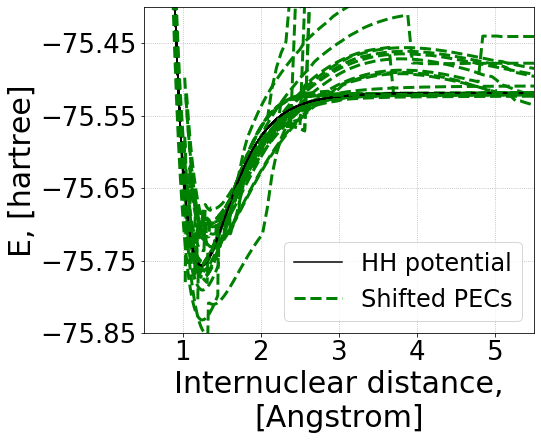

In [9]:
# Obtain a plot with all shifted PECs with respect to the HH potential E curve
# selected_sets = ['C-C']

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_HH_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_HH_all = load_pickle(save_filename)

save_filename = save_data_path + "dist_Ang_HH_pot_all_" + date + ".pkl"
dist_Ang_HH_pot_all = load_pickle(save_filename)
    
save_filename = save_data_path + "HH_pot_all_" + date + ".pkl"
HH_pot_all = load_pickle(save_filename)

for system_name in selected_sets:
    atom_type_1 = system_name.split("-")[0]
    atom_type_2 = system_name.split("-")[1]
    
    DF_merged_PEC_hartree_shifted_HH = DF_merged_PEC_hartree_shifted_HH_all[system_name]
    dist_Ang_HH_pot = dist_Ang_HH_pot_all[system_name]
    HH_pot = HH_pot_all[system_name]
    # Shift and compare all PECs with respect to the HH PEC and then calculate deviation area
    DF_dev_area_results = Plot_All_PECs_wrt_HH_pot(DF_merged_PEC_hartree_shifted_HH)

### Otain reference PECs with respect to the HH PECs

In [10]:
# Otain reference PECs with respect to the HH PECs

save_filename = save_data_path + "DF_dev_area_results_all_" + date + ".pkl"
DF_dev_area_results_all = load_pickle(save_filename)

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_HH_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_HH_all = load_pickle(save_filename)

DF_Ref_PEC_all = {}
Ref_PEC_col_name_all = {}

for system_name in selected_sets:
    print(system_name)
    atom_type_1 = system_name.split("-")[0]
    atom_type_2 = system_name.split("-")[1]
    
    DF_merged_PEC_hartree_shifted_HH = DF_merged_PEC_hartree_shifted_HH_all[system_name]
    DF_dev_area_results = DF_dev_area_results_all[system_name]
    # The PEC with the minimum deviation area is selected as a reference PEC
#     DF_Ref_PEC, Ref_PEC_col_name = Get_Ref_PECs_wrt_HH_pot(DF_dev_area_results)
#     DF_Ref_PEC, Ref_PEC_col_name = Get_Ref_PECs_wrt_HH_pot_E_bound(DF_dev_area_results)
    DF_Ref_PEC, Ref_PEC_col_name = Get_Ref_PECs_wrt_HH_pot_E_bound_norm(DF_dev_area_results)
#     DF_Ref_PEC, Ref_PEC_col_name = Get_Ref_PECs_wrt_HH_pot_derivative_weight(DF_dev_area_results)
    DF_Ref_PEC_all[system_name] = DF_Ref_PEC
    Ref_PEC_col_name_all[system_name] = Ref_PEC_col_name
    
save_filename = save_data_path + "DF_Ref_PEC_all_" + date + ".pkl"
save_pickle(save_filename, DF_Ref_PEC_all)

save_filename = save_data_path + "Ref_PEC_col_name_all_" + date + ".pkl"
save_pickle(save_filename, Ref_PEC_col_name_all)

C-C
Reference PEC: C-C_08_07
Data is saved in ./Labeling_data/Data/DF_Ref_PEC_all_20191001.pkl
Data is saved in ./Labeling_data/Data/Ref_PEC_col_name_all_20191001.pkl


In [11]:
# DF_dev_area_results

### Shift all available PECs with respect to the reference PECs

In [12]:
# Shift all available PECs with respect to the reference PECs
DF_merged_PEC_hartree_shifted_Ref_all = {}

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_HH_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_HH_all = load_pickle(save_filename)

save_filename = save_data_path + "DF_Ref_PEC_all_" + date + ".pkl"
DF_Ref_PEC_all = load_pickle(save_filename)

save_filename = save_data_path + "Ref_PEC_col_name_all_" + date + ".pkl"
Ref_PEC_col_name_all = load_pickle(save_filename)

for system_name in selected_sets:
    atom_type_1 = system_name.split("-")[0]
    atom_type_2 = system_name.split("-")[1]
    
    DF_merged_PEC_hartree_shifted_HH = DF_merged_PEC_hartree_shifted_HH_all[system_name]
    DF_Ref_PEC = DF_Ref_PEC_all[system_name]
    Ref_PEC_col_name = Ref_PEC_col_name_all[system_name]
    # Shift and compare all PECs with respect to the reference PEC
    DF_merged_PEC_hartree_shifted_Ref = \
    Get_Shifted_PECs_wrt_Ref_PEC(DF_merged_PEC_hartree_shifted_HH, 
                                 DF_Ref_PEC, Ref_PEC_col_name)
    
    DF_merged_PEC_hartree_shifted_Ref_all[system_name] = DF_merged_PEC_hartree_shifted_Ref

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_all_" + date + ".pkl"
save_pickle(save_filename, DF_merged_PEC_hartree_shifted_Ref_all)

Data is saved in ./Labeling_data/Data/DF_merged_PEC_hartree_shifted_Ref_all_20191001.pkl


In [13]:
# DF_merged_PEC_hartree_shifted_Ref

### Plot all PECs shifted with respect to the reference PEC

In [14]:
# save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_all_" + date + ".pkl"
# DF_merged_PEC_hartree_shifted_Ref_all = load_pickle(save_filename)

# for system_name in selected_sets:
#     atom_type_1 = system_name.split("-")[0]
#     atom_type_2 = system_name.split("-")[1]
    
#     DF_merged_PEC_hartree_shifted_Ref = DF_merged_PEC_hartree_shifted_Ref_all[system_name]

#     Plot_All_Original_PECs_Shifted_Ref_PEC(DF_merged_PEC_hartree_shifted_Ref)

### Compute derivative of PECs for checking data points that showed different trend (slope)

In [15]:
# Compute derivative of PECs for checking data points that showed different trend (slope)
# DF_merged_PEC_hartree_shifted_Ref_derv_all = {}
DF_merged_PEC_hartree_shifted_Ref_derv_all = {}
DF_merged_PEC_hartree_shifted_Ref_norm_derv_all = {}

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_Ref_all = load_pickle(save_filename)

for system_name in selected_sets:
    atom_type_1 = system_name.split("-")[0]
    atom_type_2 = system_name.split("-")[1]
    
    DF_merged_PEC_hartree_shifted_Ref = DF_merged_PEC_hartree_shifted_Ref_all[system_name]
    
#     DF_merged_PEC_hartree_shifted_Ref_derv = \
#     Get_derivative_merged_PEC_hartree_shifted_Ref(DF_merged_PEC_hartree_shifted_Ref)

#     DF_merged_PEC_hartree_shifted_Ref_derv_all[system_name] = \
#     DF_merged_PEC_hartree_shifted_Ref_derv
    
    DF_merged_PEC_hartree_shifted_Ref_norm_derv = \
    Get_norm_derivative_merged_PEC_hartree_shifted_Ref(DF_merged_PEC_hartree_shifted_Ref, 
                                                      atom_type_1, atom_type_2)
    
    DF_merged_PEC_hartree_shifted_Ref_norm_derv_all[system_name] = \
    DF_merged_PEC_hartree_shifted_Ref_norm_derv
    
# save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_derv_all_" + date + ".pkl"
# save_pickle(save_filename, DF_merged_PEC_hartree_shifted_Ref_derv_all)

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_norm_derv_all_" + date + ".pkl"
save_pickle(save_filename, DF_merged_PEC_hartree_shifted_Ref_norm_derv_all)

C C 06 08
C C 08 07
C C 10 08
C C 06 09
C C 06 10
C C 08 09
C C 04 08
C C 04 09
C C 04 10
C C 08 06
C C 08 08
C C 10 09
C C 02 01
C C 04 07
C C 06 06
C C 08 10
C C 10 10
C C 02 02
C C 02 03
C C 02 04
C C 02 05
C C 02 06
C C 02 08
C C 02 09
C C 02 10
C C 04 02
C C 04 03
C C 04 04
C C 04 05
C C 04 06
C C 06 03
C C 06 04
C C 06 05
C C 06 07
C C 08 04
C C 08 05
C C 10 05
C C 10 06
C C 10 07
Data is saved in ./Labeling_data/Data/DF_merged_PEC_hartree_shifted_Ref_norm_derv_all_20191001.pkl


In [21]:
# DF_merged_PEC_hartree_shifted_Ref_norm_derv

In [22]:
# DF_merged_PEC_hartree_shifted_Ref_norm_derv["Ref_E_derv"]

### Generate a label code for each data point, and dataframe

In [24]:
# Generate a label code for each data point, and dataframe
DF_merged_PEC_hartree_shifted_Ref_labels_all = {}

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_Ref_all = load_pickle(save_filename)

# save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_derv_all_" + date + ".pkl"
# DF_merged_PEC_hartree_shifted_Ref_derv_all = load_pickle(save_filename)

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_norm_derv_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_Ref_norm_derv_all = load_pickle(save_filename)

for system_name in selected_sets:
    atom_type_1 = system_name.split("-")[0]
    atom_type_2 = system_name.split("-")[1]
    
    DF_merged_PEC_hartree_shifted_Ref = DF_merged_PEC_hartree_shifted_Ref_all[system_name]
#     DF_merged_PEC_hartree_shifted_Ref_derv = DF_merged_PEC_hartree_shifted_Ref_derv_all[system_name]
    DF_merged_PEC_hartree_shifted_Ref_norm_derv = DF_merged_PEC_hartree_shifted_Ref_norm_derv_all[system_name]
    
#     DF_merged_PEC_hartree_shifted_Ref_labels = \
#     Get_labels_merged_PEC_hartree_shifted_Ref(DF_merged_PEC_hartree_shifted_Ref, 
#                                               DF_merged_PEC_hartree_shifted_Ref_derv)
    
    DF_merged_PEC_hartree_shifted_Ref_labels = \
    Get_labels_merged_PEC_hartree_shifted_Ref(DF_merged_PEC_hartree_shifted_Ref, 
                                              DF_merged_PEC_hartree_shifted_Ref_norm_derv)
    
    DF_merged_PEC_hartree_shifted_Ref_labels_all[system_name] = DF_merged_PEC_hartree_shifted_Ref_labels
    
    
save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_labels_all_" + date + ".pkl"
save_pickle(save_filename, DF_merged_PEC_hartree_shifted_Ref_labels_all)

C-C_06_08-The number of data for energy 283:
C-C_06_08-The number of data for energy derivative 283:
C-C_08_07-The number of data for energy 283:
C-C_08_07-The number of data for energy derivative 283:
C-C_10_08-The number of data for energy 283:
C-C_10_08-The number of data for energy derivative 283:
C-C_06_09-The number of data for energy 283:
C-C_06_09-The number of data for energy derivative 283:
C-C_06_10-The number of data for energy 283:
C-C_06_10-The number of data for energy derivative 283:
C-C_08_09-The number of data for energy 283:
C-C_08_09-The number of data for energy derivative 283:
C-C_04_08-The number of data for energy 283:
C-C_04_08-The number of data for energy derivative 283:
C-C_04_09-The number of data for energy 283:
C-C_04_09-The number of data for energy derivative 283:
C-C_04_10-The number of data for energy 283:
C-C_04_10-The number of data for energy derivative 283:
C-C_08_06-The number of data for energy 283:
C-C_08_06-The number of data for energy deriva

In [25]:
save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_labels_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_Ref_labels_all = load_pickle(save_filename)

### Plot all PECs with classification of good and bad points

In [26]:
# Good and bad data points are classified. Check "Plot_PECs_wrt_Ref_PEC"

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_Ref_all = load_pickle(save_filename)

save_filename = save_data_path + "DF_merged_PEC_hartree_shifted_Ref_labels_all_" + date + ".pkl"
DF_merged_PEC_hartree_shifted_Ref_labels_all = load_pickle(save_filename)

for system_name in selected_sets:
#     atom_type_1 = system_name.split("-")[0]
#     atom_type_2 = system_name.split("-")[1]
    
    DF_merged_PEC_hartree_shifted_Ref = DF_merged_PEC_hartree_shifted_Ref_all[system_name]
    DF_merged_PEC_hartree_shifted_Ref_labels = DF_merged_PEC_hartree_shifted_Ref_labels_all[system_name]
    
    # Plot graphs that show the good and bad data points
    Plot_PECs_wrt_Ref_PEC(DF_merged_PEC_hartree_shifted_Ref, DF_merged_PEC_hartree_shifted_Ref_labels)
    

In [27]:
DF_merged_PEC_hartree_shifted_Ref

,dist_Bohr,dist_Ang,HH_pot,Ref_E,Lower,Upper,C-C_06_08,C-C_08_07,C-C_10_08,C-C_06_09,...,C-C_04_06,C-C_06_03,C-C_06_04,C-C_06_05,C-C_06_07,C-C_08_04,C-C_08_05,C-C_10_05,C-C_10_06,C-C_10_07
0.532903,0.532903,0.282000,-35.579389,-58.381515,-62.620112,-52.557252,-58.378558,-58.381515,-58.408204,-58.383059,...,-58.389942,-58.398189,-58.394893,NaN,-58.378643,-58.397135,-58.414602,-58.434996,-58.445891,-58.418143
0.646286,0.646286,0.342000,-50.941033,-64.574379,-66.989989,-61.132100,-64.574551,-64.574379,-64.598997,-64.576204,...,-64.582607,-64.595056,-64.587236,NaN,-64.572784,-64.594731,-64.606983,-64.625928,-64.635806,-64.608338
0.759670,0.759670,0.402000,-60.330034,-68.107130,-69.562311,-66.147045,-68.108666,-68.107130,-68.128568,-68.109168,...,-68.114205,-68.128192,-68.118413,NaN,-68.106240,-68.128167,-68.138235,-68.154651,-68.164316,-68.137277
0.873053,0.873053,0.462000,-66.082074,-70.272843,-71.228450,-69.042000,-70.275104,-70.272843,-70.290667,-70.274974,...,-70.278594,-70.292734,-70.282278,NaN,-70.272249,-70.292770,-70.302208,-70.314960,-70.325121,-70.298549
0.986437,0.986437,0.522000,-69.626579,-71.714347,-72.402648,-70.882077,-71.716526,-71.714347,-71.728774,-71.715918,...,-71.718872,-71.731357,-71.722075,NaN,-71.713609,-71.731384,-71.742066,-71.749394,-71.761642,-71.735732
1.099821,1.099821,0.582000,-71.832094,-72.770729,-73.310388,-72.147829,-72.771723,-72.770729,-72.782601,-72.770567,...,-72.774726,-72.779592,-72.777763,NaN,-72.769081,-72.779624,-72.797632,-72.793849,-72.814313,-72.789056
1.213204,1.213204,0.642000,-73.223027,-73.603412,-74.027982,-73.108593,-73.602554,-73.603412,-73.613578,-73.601284,...,-73.606726,-73.594901,-73.610208,NaN,-73.600500,-73.594952,-73.630013,-73.606072,-73.644735,-73.619846
1.228322,1.228322,0.650000,-73.365612,-73.700406,-74.110015,-73.220876,-73.699412,-73.700406,-73.710417,-73.698125,...,-73.703559,-73.689424,-73.707092,NaN,-73.697418,-73.689476,-73.726901,-73.700211,-73.741412,-73.716599
1.243440,1.243440,0.658000,-73.500037,-73.794187,-74.188932,-73.329776,-73.793097,-73.794187,-73.804030,-73.791810,...,-73.797136,-73.780814,-73.800714,NaN,-73.791181,-73.780868,-73.820527,-73.791230,-73.834833,-73.810098
1.258558,1.258558,0.666000,-73.626807,-73.884731,-74.264813,-73.435351,-73.883584,-73.884731,-73.894378,-73.882230,...,-73.887205,-73.869125,-73.891089,NaN,-73.881684,-73.869180,-73.910907,-73.879179,-73.925013,-73.900354


In [28]:
DF_merged_PEC_hartree_shifted_Ref_labels

,dist_Ang,Ref_E,Lower,Upper,C-C_06_08_label,C-C_08_07_label,C-C_10_08_label,C-C_06_09_label,C-C_06_10_label,C-C_08_09_label,...,C-C_04_06_label,C-C_06_03_label,C-C_06_04_label,C-C_06_05_label,C-C_06_07_label,C-C_08_04_label,C-C_08_05_label,C-C_10_05_label,C-C_10_06_label,C-C_10_07_label
0.532903,0.282000,-58.381515,-62.620112,-52.557252,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
0.646286,0.342000,-64.574379,-66.989989,-61.132100,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
0.759670,0.402000,-68.107130,-69.562311,-66.147045,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
0.873053,0.462000,-70.272843,-71.228450,-69.042000,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
0.986437,0.522000,-71.714347,-72.402648,-70.882077,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
1.099821,0.582000,-72.770729,-73.310388,-72.147829,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
1.213204,0.642000,-73.603412,-74.027982,-73.108593,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
1.228322,0.650000,-73.700406,-74.110015,-73.220876,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
1.243440,0.658000,-73.794187,-74.188932,-73.329776,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
1.258558,0.666000,-73.884731,-74.264813,-73.435351,good,good,good,good,good,good,...,good,good,good,NaN,good,good,good,good,good,good
